In [1]:
import camb
import healpy as hp
import pysm3
import pysm3.units as u
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import pickle as pl
import time

In [2]:
nside = 1024

In [3]:
mfile = '/global/homes/l/lonappan/binary_GAL_mask_N1024.fits'
mask = hp.read_map(mfile)

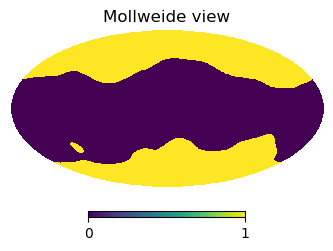

In [4]:
hp.mollview(mask, sub=(1,2,1))

In [5]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,  As=2e-9, ns=0.965, halofit_version='mead', lmax=7000)
results = camb.get_results(pars)
lensed_cl = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['lensed_scalar']
cmb_map = hp.synfast(lensed_cl.T, nside=nside, new=True)

In [6]:
freqs = np.array(["27", "39", "93", "145", "225", "280"])
fwhm = np.array([7.4, 5.1, 2.2, 1.4, 1.0, 0.9])
nlev_p = np.array([23.6, 13.1, 2.3, 2.2, 4.8, 2.2])

In [7]:
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1"])

In [43]:
def noise_map(nside,nlev_p):
    nl_p = np.ones(3*nside) * np.radians(nlev_p / 60.)**2
    nlev_t = nlev_p / np.sqrt(2)
    nl_t = np.ones(3*nside) * np.radians(nlev_t / 60.)**2
    cl_s = [nl_t, nl_p, nl_p, nl_p*0]
    return hp.synfast(cl_s, nside=nside, new=True)

def sky_map_wfg(freqs, fwhm, nlev_p, nside):
    maps = []
    for i in tqdm(range(len(freqs))):
        fg = sky.get_emission(int(freqs[i])*u.GHz)
        fg = fg.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(int(freqs[i])*u.GHz))
        signal = cmb_map + fg.value
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        noise = noise_map(nside, nlev_p[i])
        maps.append(signal + noise)
    return maps
def sky_map_wofg(freqs, fwhm, nlev_p, nside):
    maps = []
    for i in tqdm(range(len(freqs))):
        signal = cmb_map
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        noise = noise_map(nside, nlev_p[i])
        maps.append(signal + noise)
    return maps
def sky_map_fgonly(freqs, fwhm):
    maps = []
    for i in tqdm(range(len(freqs))):
        fg = sky.get_emission(int(freqs[i])*u.GHz)
        fg = fg.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(int(freqs[i])*u.GHz))
        signal = fg.value
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        maps.append(signal)
    return maps

In [9]:
sky_maps = sky_map_wfg(freqs, fwhm, nlev_p, nside)

100%|██████████| 6/6 [02:34<00:00, 25.80s/it]


In [34]:
emaps = []
for m in tqdm(sky_maps):
    elm = hp.map2alm(m)[2]
    emaps.append([hp.alm2map(elm,nside=nside)*mask])
emaps = np.array(emaps)

100%|██████████| 6/6 [01:39<00:00, 16.55s/it]


In [35]:
sys.path.append('../')

In [12]:
%load_ext autoreload
%autoreload 2
from pynilc.nilc import NILC
from pynilc.needlets import NeedletTransform
from pynilc.sht import HealpixDUCC

In [13]:
bandcenters = np.array([0, 50, 100, 200, 400, 800, 1000])
nfilters = NeedletTransform.CosineNeedlet(bandcenters)

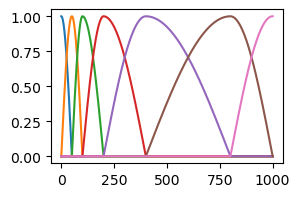

In [14]:
plt.figure(figsize=(3,2))
for i in range(len(nfilters)):
    plt.plot(nfilters[i])

In [36]:
Bmap = hp.alm2map(hp.map2alm(cmb_map)[2], nside=nside)

In [12]:
#nilc_hp = NILC(freqs, fwhm, nfilters, backend='healpy')
# nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,common_fwhm=10)

In [13]:
# ilc_map_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=0)

In [14]:
# nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside)
# ilc_emap_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=1)

In [37]:
nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,required_num_modes=500)
ilc_bmap_dc, ilc_weights_dc = nilc_dc.component_separation(emaps)

Level 1 parallel processing is enabled
Computing temperature alms


Processing Needlet Scales: 100%|██████████| 7/7 [00:55<00:00,  7.87s/it]


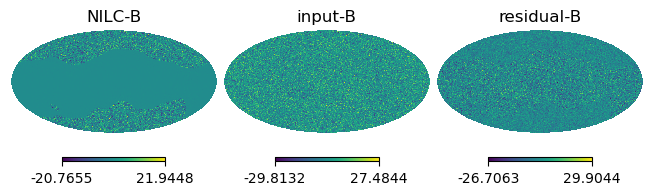

In [22]:
hp.mollview(ilc_bmap_dc, title='NILC-B',sub=(1,3,1))
hp.mollview(Bmap, title='input-B',sub=(1,3,2))
hp.mollview(ilc_bmap_dc-Bmap, title='residual-B',sub=(1,3,3))

In [23]:
def arc2cl(arc):
    return np.radians(arc/60)**2
def cl2arc(cl):
    return np.rad2deg(np.sqrt(cl))*60
def noise(arr):
    return cl2arc(1/sum(1/arc2cl(arr)))

In [31]:
noise_maps = []
for i in range(len(freqs)):
    noise_maps.append(noise_map(nside, nlev_p[i]))

In [38]:
ilc_noise = nilc_dc.calculate_residuals(noise_maps, ilc_weights_dc,field=2)

Computing B-mode alms


Calculating residuals: 100%|██████████| 7/7 [00:21<00:00,  3.01s/it]


In [39]:
cl = hp.anafast(ilc_bmap_dc)

In [44]:
fgsignal = sky_map_fgonly(freqs, fwhm)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:03<00:00, 20.64s/it]


In [46]:
fgbmaps = []
for m in tqdm(fgsignal):
    elm = hp.map2alm(m)[2]
    fgbmaps.append([hp.alm2map(elm,nside=nside)*mask])
fgbmaps = np.array(fgbmaps)

100%|██████████| 6/6 [01:36<00:00, 16.09s/it]


In [47]:
fg_res = nilc_dc.calculate_residuals(fgbmaps, ilc_weights_dc, field=0)

Computing temperature alms


Calculating residuals: 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


(1e-08, 0.0001)

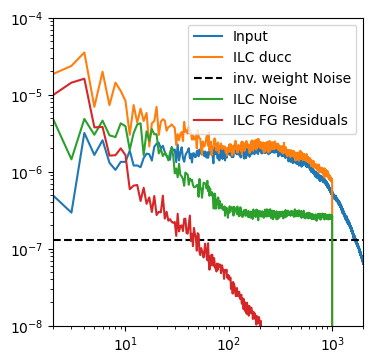

In [48]:
plt.figure(figsize=(4,4))
plt.loglog(hp.anafast(Bmap), label='Input')
plt.loglog(cl/np.mean(mask), label='ILC ducc')
plt.axhline(arc2cl(noise(nlev_p)), color='k', ls='--', label='inv. weight Noise')
plt.loglog(hp.anafast(ilc_noise), label='ILC Noise')
plt.loglog(hp.anafast(fg_res), label='ILC FG Residuals')
plt.loglog()
plt.legend()
plt.xlim(2, 2000)
plt.ylim(1e-8, 1e-4)